In [9]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

tf.__version__

'2.1.0'

In [10]:
train, test = tf.keras.datasets.mnist.load_data()
X, y = np.concatenate([train[0], test[0]]), np.concatenate([train[1], test[1]])
X = X / 255.0
X.shape, y.shape

((70000, 28, 28), (70000,))

8

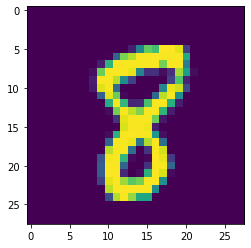

In [11]:
idx = 69420
plt.imshow(X[idx])
y[idx]

In [12]:
def block(f, type='conv', ks=2, s=1, a='relu'):
    assert type in ['conv', 'deconv']
    layer = tf.keras.layers.Conv2D if type == 'conv' else \
            tf.keras.layers.Conv2DTranspose
    c = layer(f, (ks, ks), strides=(s, s), activation=a)
    bn = tf.keras.layers.BatchNormalization()
    return lambda x: bn(c(x))

In [13]:
def project(units, a='relu'):
    f = tf.keras.layers.Flatten()
    d = tf.keras.layers.Dense(units, activation=a)
    return lambda x: d(f(x))

In [14]:
def reshape(shape):
    d = tf.keras.layers.Dense(np.prod(shape))
    r = tf.keras.layers.Reshape(shape)
    return lambda x: r(d(x))

In [15]:
def encode():
    i = tf.keras.Input((28, 28))
    x = i
    x = tf.keras.layers.Reshape((28, 28, 1))(x)
    x = block(64, type='conv', ks=2, s=1, a='relu')(x)
    x = block(32, type='conv', ks=2, s=1, a='relu')(x)
    x = block(16, type='conv', ks=2, s=2, a='relu')(x)
    x = block(8 , type='conv', ks=2, s=2, a='relu')(x)
    x = block(4 , type='conv', ks=2, s=2, a='relu')(x)
    x = project(32, a='tanh')(x)
    m = tf.keras.Model(i, x, name='encoder')
    return lambda x: m(x)

In [16]:
def decode():
    i = tf.keras.Input((32,))
    x = i
    x = reshape((6, 6, 1))(x)
    x = block(8  , type='deconv', ks=2, s=2, a='relu')(x)
    x = block(16 , type='deconv', ks=2, s=2, a='relu')(x)
    x = block(32 , type='deconv', ks=2, s=1, a='relu')(x)
    x = block(64 , type='deconv', ks=2, s=1, a='relu')(x)
    x = block(128, type='deconv', ks=2, s=1, a='relu')(x)
    x = block(64 , type='deconv', ks=2, s=1, a='relu')(x)
    x = block(1  , type='deconv', ks=1, s=1, a='sigmoid')(x)
    x = tf.keras.layers.Reshape((28, 28))(x)
    m = tf.keras.Model(i, x, name='decoder')
    return lambda x: m(x)

In [17]:
class AE:
    def __init__(self):
        self.e = encode()
        self.d = decode()

        i = tf.keras.Input((28, 28), name='input')
        x = i
        x = self.e(x)
        x = self.d(x)

        self.net = tf.keras.Model(i, x, name='AE')
        self.net.compile(
            optimizer='adam',
            loss='binary_crossentropy',
            metrics=[],
        )

    def __call__(self, x):
        return self.net(x)

In [18]:
ae = AE()
ae.net.summary()

Model: "AE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 28, 28)]          0         
_________________________________________________________________
encoder (Model)              (None, 32)                12940     
_________________________________________________________________
decoder (Model)              (None, 28, 28)            79137     
Total params: 92,077
Trainable params: 91,203
Non-trainable params: 874
_________________________________________________________________


In [ ]:
ae.net.fit(
    x=X,
    y=X,
    batch_size=512,
    epochs=20,
    workers=8,
    use_multiprocessing=True,
)

Train on 70000 samples
Epoch 1/20
70000/70000 [==============================] - 11s 152us/sample - loss: 0.2082
Epoch 2/20
70000/70000 [==============================] - 10s 150us/sample - loss: 0.2052
Epoch 3/20
70000/70000 [==============================] - 10s 145us/sample - loss: 0.2024
Epoch 4/20
70000/70000 [==============================] - 10s 147us/sample - loss: 0.2001
Epoch 5/20
70000/70000 [==============================] - 11s 151us/sample - loss: 0.2025
Epoch 6/20
70000/70000 [==============================] - 11s 150us/sample - loss: 0.1969
Epoch 7/20
70000/70000 [==============================] - 11s 155us/sample - loss: 0.1931
Epoch 8/20
70000/70000 [==============================] - 11s 152us/sample - loss: 0.1930
Epoch 9/20
70000/70000 [==============================] - 11s 152us/sample - loss: 0.1981
Epoch 10/20
70000/70000 [==============================] - 11s 151us/sample - loss: 0.1880
Epoch 11/20
70000/70000 [==============================] - 11s 153us/sample 

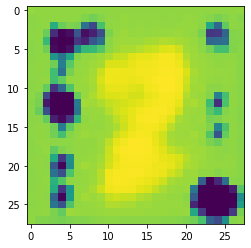

In [24]:
x = X[idx][np.newaxis, ...]
rx = ae(x)[0]
plt.imshow(rx)